In [72]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed, Dense
import matplotlib.pyplot as plt
import matplotlib as mpl
from tensorflow.keras.optimizers import Adam


In [2]:
mpl.rcParams['figure.figsize'] = (20, 6)  # Width, Height in inches

In [3]:
file_name = "PGMs_Prices_V3.xlsx"
#cols = ['Date', 'AU_Return', 'AG_Return', 'PT_Return', 'PD_Return', 'Portfolio_Value']

#df = pd.read_excel(file_name, usecols = cols)
df = pd.read_excel(file_name)

df['Date'] = pd.to_datetime(df['Date'])
# Convert timestamps to Unix timestamps (seconds since epoch)
df['UnixTs'] = df['Date'].astype('int64') // 10**9  # Convert nanoseconds to seconds


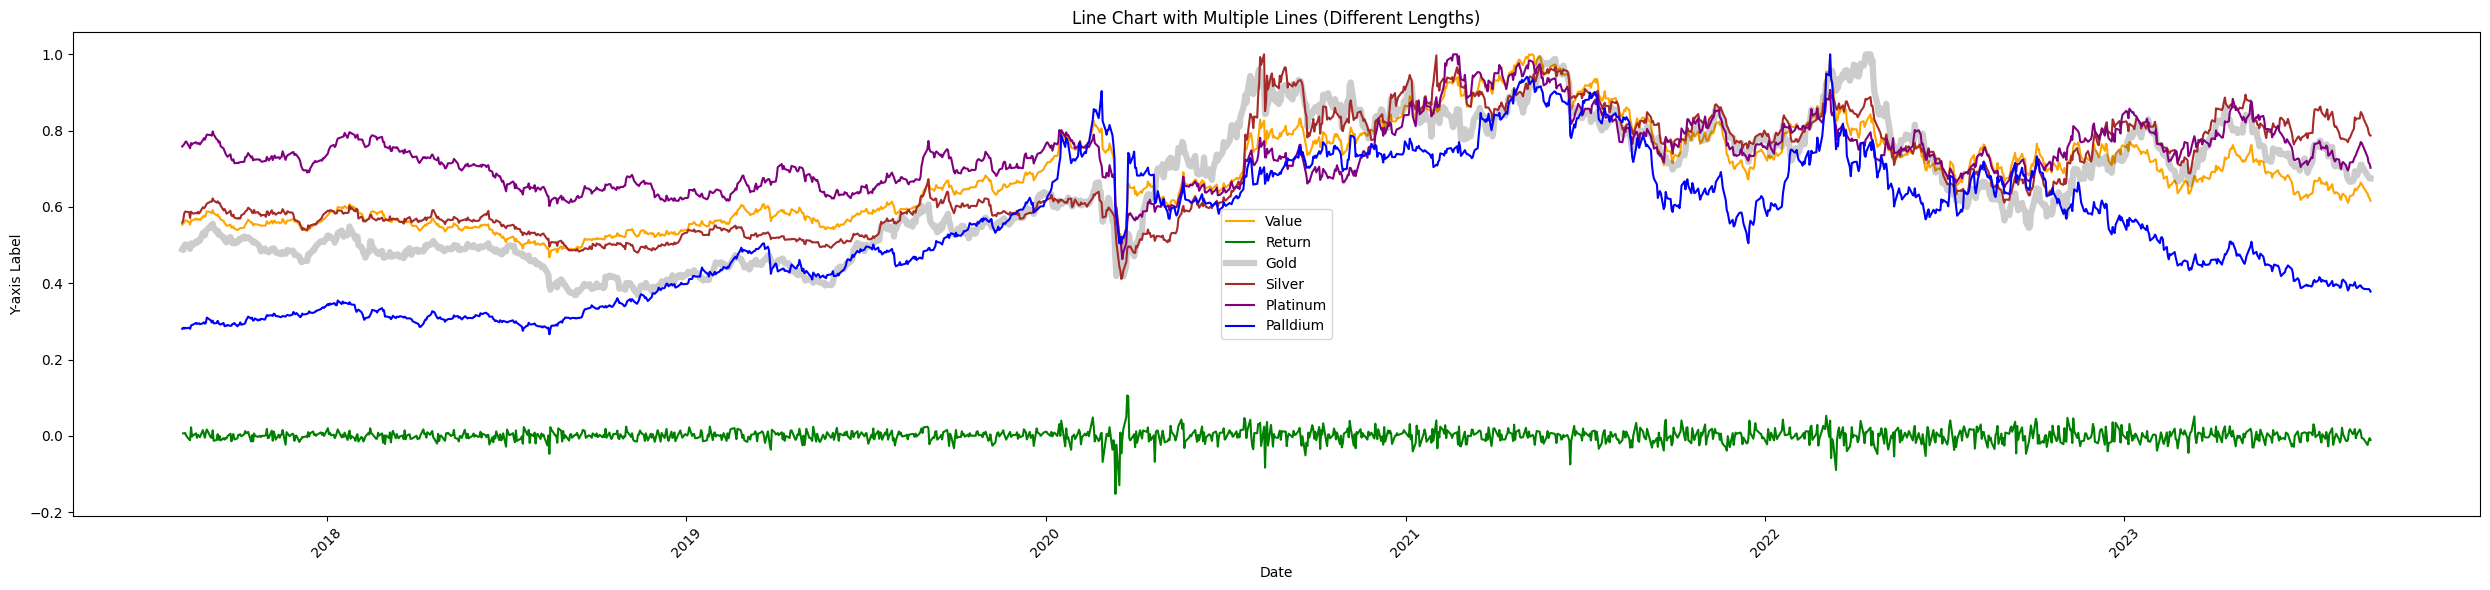

In [4]:
# Create a line chart with multiple lines using the overlapping data
plt.figure(figsize=(25, 6))

# Corresponding Y-axis values for two lines (different lengths)
y_gold = df['AU_PX_LAST']
y_silver = df['AG_PX_LAST']
y_platinum = df['PT_PX_LAST']
y_palldium = df['PD_PX_LAST']

total_value = df['Portfolio_Value']
by_day_return = df['Portfolio_Return']

# scale Y axis
y_gold_scaled = [val / max(y_gold) for val in y_gold]
y_silver_scaled = [val / max(y_silver) for val in y_silver]
y_pl_scaled = [val / max(y_platinum) for val in y_platinum]
y_pa_scaled = [val / max(y_palldium) for val in y_palldium]

value_scaled = [val /max(total_value) for val in total_value]

#TODO model total returns
#return_scaled = [val /max(by_day_return) for val in total_value]


plt.plot(df['Date'], value_scaled, label='Value', linestyle='-', color='orange')
plt.plot(df['Date'], df['Portfolio_Return'], label='Return', linestyle='-', color='green')

plt.plot(df['Date'], y_gold_scaled, label='Gold', linewidth=4.5, linestyle='-',  alpha=0.2, color='black')
plt.plot(df['Date'], y_silver_scaled, label='Silver', linestyle='-', color='brown')
plt.plot(df['Date'], y_pl_scaled, label='Platinum', linestyle='-', color='purple')
plt.plot(df['Date'], y_pa_scaled, label='Palldium', linestyle='-', color='blue')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Y-axis Label')
plt.title('Line Chart with Multiple Lines (Different Lengths)')

# Format the date ticks on the X-axis for better readability
plt.xticks(rotation=45)

# Add a legend
plt.legend()

# Display the chart
plt.tight_layout()
plt.show()


Portfolio Volatility (Single Asset): 4       0.697323
5       0.745948
6       0.747162
7       1.229677
8       1.150228
          ...   
1527    1.344613
1528    1.343057
1529    1.374407
1530    0.878824
1531    0.709328
Name: Portfolio_Return, Length: 1528, dtype: float64


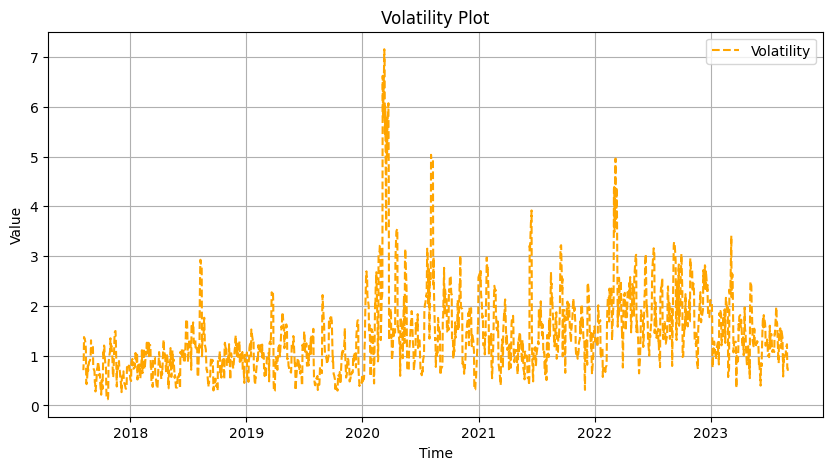

In [54]:
# calculate variance and volatility based on returns
# Define the rolling window size (e.g., 5 days)
window_size = 5

day_volatility = pd.Series(by_day_return).rolling(window=window_size).std().dropna() * 100
day_volatility.shape

#portfolio_volatility = np.std(by_day_return)
print("Portfolio Volatility (Single Asset):", day_volatility)

# scale by 10o times
df['Volatility'] = day_volatility 

# Plot the volatility
plt.figure(figsize=(10, 5))
plt.plot(df['Date'].drop(df.index[:5]), day_volatility, label='Volatility', linestyle='--', color='orange')
#plt.plot(df['Date'], returns, label='Returns', marker='o', linestyle='-', color='blue')
plt.title('Volatility Plot')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [65]:
# normalize data
# df.drop(columns=['Date'], inplace=True)
numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_columns

# Calculate original means and standard deviations before normalization
original_means = df[numeric_columns].mean()
original_std_devs = df[numeric_columns].std()


normalized_data = (df[numeric_columns] - original_means) / original_std_devs
# first 4 and last 1 is na for volatility
normalized_data.fillna(0)

# normalized_data = normalized_data.drop('Volatility', axis=1)

test_df = normalized_data[['UnixTs', 'Volatility']]


In [77]:
# Windowing: Creating sequences/windows
sequence_length = 5  # which is the rolling window dates
sequences = []
for i in range(len(normalized_data) - sequence_length):
    sequences.append(normalized_data[i:i+sequence_length])
sequences = np.array(sequences)

In [78]:
# Split data into train and validation sets
train_size = int(0.8 * len(sequences))
train_data = sequences[:train_size]
val_data = sequences[train_size:]

In [79]:
# Define the autoencoder model
num_features = 34 # ??

model = Sequential([
    LSTM(64, activation='relu', input_shape=(sequence_length, num_features), return_sequences=True),
    LSTM(32, activation='relu', return_sequences=False),
    RepeatVector(sequence_length),
    LSTM(32, activation='relu', return_sequences=True),
    LSTM(64, activation='relu', return_sequences=True),
    TimeDistributed(Dense(num_features))
])

custom_learning_rate = 0.00001  # Adjust this value as needed
adam_optimizer = Adam(learning_rate=custom_learning_rate)

In [80]:
model.compile(optimizer=adam_optimizer, loss='mse')

# Training the autoencoder
model.fit(train_data, train_data, epochs=100, batch_size=32, validation_data=(val_data, val_data))


Epoch 1/100
39/39 [==============================] - 5s 25ms/step - loss: nan - val_loss: nan
Epoch 2/100
39/39 [==============================] - 0s 9ms/step - loss: nan - val_loss: nan
Epoch 3/100
39/39 [==============================] - 0s 9ms/step - loss: nan - val_loss: nan
Epoch 4/100
39/39 [==============================] - 0s 8ms/step - loss: nan - val_loss: nan
Epoch 5/100
39/39 [==============================] - 0s 9ms/step - loss: nan - val_loss: nan
Epoch 6/100
39/39 [==============================] - 0s 9ms/step - loss: nan - val_loss: nan
Epoch 7/100
39/39 [==============================] - 0s 9ms/step - loss: nan - val_loss: nan
Epoch 8/100
39/39 [==============================] - 0s 9ms/step - loss: nan - val_loss: nan
Epoch 9/100
39/39 [==============================] - 0s 9ms/step - loss: nan - val_loss: nan
Epoch 10/100
39/39 [==============================] - 0s 9ms/step - loss: nan - val_loss: nan
Epoch 11/100
39/39 [==============================] - 0s 8ms/step - 

In [17]:
# Reconstruction of validation data
predicted_val_data = model.predict(val_data)

# Calculating reconstruction loss
reconstruction_losses = np.mean(np.square(val_data - predicted_val_data), axis=(1, 2))

# MSE
mse = np.mean((val_data - predicted_val_data) ** 2)
rmse = np.sqrt(mse)

print(f"mse: {mse} \nrmse: {rmse}")


# Define a threshold for detecting regime changes
# Calculate mean and standard deviation of reconstruction errors on validation set
error_mean = np.mean(reconstruction_losses)
error_std = np.std(reconstruction_losses)

# Set threshold as a multiple of standard deviation above the mean error
#threshold = error_mean + 2 * error_std  # Adjust the multiplier as needed
threshold = error_mean - error_std/8

print(f"error_mean {error_mean}\nerror_std {error_std}\nthreshold {threshold}")

# Detect regime changes based on the threshold for validation dataset
regime_change_indices_val = np.where(reconstruction_losses > threshold)[0]
regime_change_indices_val

# Calculate reconstruction errors for training data
predicted_train_data = model.predict(train_data)
reconstruction_errors_train = np.mean(np.square(train_data - predicted_train_data),  axis=(1, 2))
regime_change_indices_train = np.where(reconstruction_errors_train > threshold)[0]

all_regime_change_indices = np.concatenate((regime_change_indices_train, regime_change_indices_val))

all_regime_change_indices

mse: nan 
rmse: nan
error_mean nan
error_std nan
threshold nan


array([], dtype=int64)

In [18]:
predict_portfolio = np.concatenate([predicted_train_data, predicted_val_data], axis=0)
# s = np.append(predict_portfolio, np.full(sequence_length, predict_portfolio[-1]))
# df_pred = df.assign(New_Column=s)

# # Get the shape of the NumPy array
# num_rows, temp, num_cols = predict_portfolio.shape

# Reshape the 3D array to 2D, dropping the middle dimension
reshaped_data = predict_portfolio.reshape(-1, predict_portfolio.shape[-1])

# Convert the 2D NumPy array to a DataFrame
df_pred = pd.DataFrame(reshaped_data)
print(numeric_columns)
df_pred.columns = numeric_columns

# print(df_pred.head())  # Displaying the first few rows for verification
print(df_pred.columns)



['Portfolio_Return', 'Portfolio_Value', 'AU_Return', 'AG_Return', 'PT_Return', 'PD_Return', 'AU_PX_LAST', 'AG_PX_LAST', 'PT_PX_LAST', 'PD_PX_LAST', 'AU_PX_OPEN', 'AU_PX_LOW', 'AU_PX_HIGH', 'AG_PX_OPEN', 'AG_PX_LOW', 'AG_PX_HIGH', 'PT_PX_OPEN', 'PT_PX_LOW', 'PT_PX_HIGH', 'PD_PX_OPEN', 'PD_PX_LOW', 'AU_INTRA_HL', 'AG_INTRA_HL', 'PT_INTRA_HL', 'AU_INTRA_OC', 'AG_INTRA_OC', 'PT_INTRA_OC', 'PD_INTRA_OC', 'ICE Libor 1M PX_Last', 'ICE Libor 3M PX_Last', 'China Core CPI', 'US CPI Urban Consumer Index', 'UnixTs']
Index(['Portfolio_Return', 'Portfolio_Value', 'AU_Return', 'AG_Return',
       'PT_Return', 'PD_Return', 'AU_PX_LAST', 'AG_PX_LAST', 'PT_PX_LAST',
       'PD_PX_LAST', 'AU_PX_OPEN', 'AU_PX_LOW', 'AU_PX_HIGH', 'AG_PX_OPEN',
       'AG_PX_LOW', 'AG_PX_HIGH', 'PT_PX_OPEN', 'PT_PX_LOW', 'PT_PX_HIGH',
       'PD_PX_OPEN', 'PD_PX_LOW', 'AU_INTRA_HL', 'AG_INTRA_HL', 'PT_INTRA_HL',
       'AU_INTRA_OC', 'AG_INTRA_OC', 'PT_INTRA_OC', 'PD_INTRA_OC',
       'ICE Libor 1M PX_Last', 'ICE Libor 3M P

In [19]:
denormalized_predictions = df_pred * original_std_devs + original_means
denormalized_predictions['Date'] = pd.to_datetime(denormalized_predictions['UnixTs'], unit='s')  # 's' for seconds, 'ms' for milliseconds

print(denormalized_predictions.head)

<bound method NDFrame.head of       Portfolio_Return  Portfolio_Value  AU_Return  AG_Return  PT_Return  \
0            -0.009657     9.352789e+06  -0.000743   0.001098  -0.010879   
1            -0.007085     9.397874e+06  -0.004090  -0.006053  -0.011134   
2            -0.012316     9.427363e+06  -0.009811  -0.015290  -0.018227   
3            -0.021633     9.556311e+06  -0.022053  -0.025997  -0.025732   
4            -0.007173     9.786263e+06  -0.011277  -0.010806  -0.009816   
...                ...              ...        ...        ...        ...   
7635         -0.010881     8.727580e+06  -0.014672  -0.011444  -0.004208   
7636         -0.004037     8.979436e+06   0.013383   0.006898  -0.001913   
7637          0.010168     9.193908e+06   0.019739   0.012484   0.007579   
7638          0.012816     9.140203e+06   0.028997   0.018627   0.011688   
7639          0.005540     8.921891e+06   0.007305   0.005871   0.010270   

      PD_Return  AU_PX_LAST  AG_PX_LAST  PT_PX_LAST   PD_

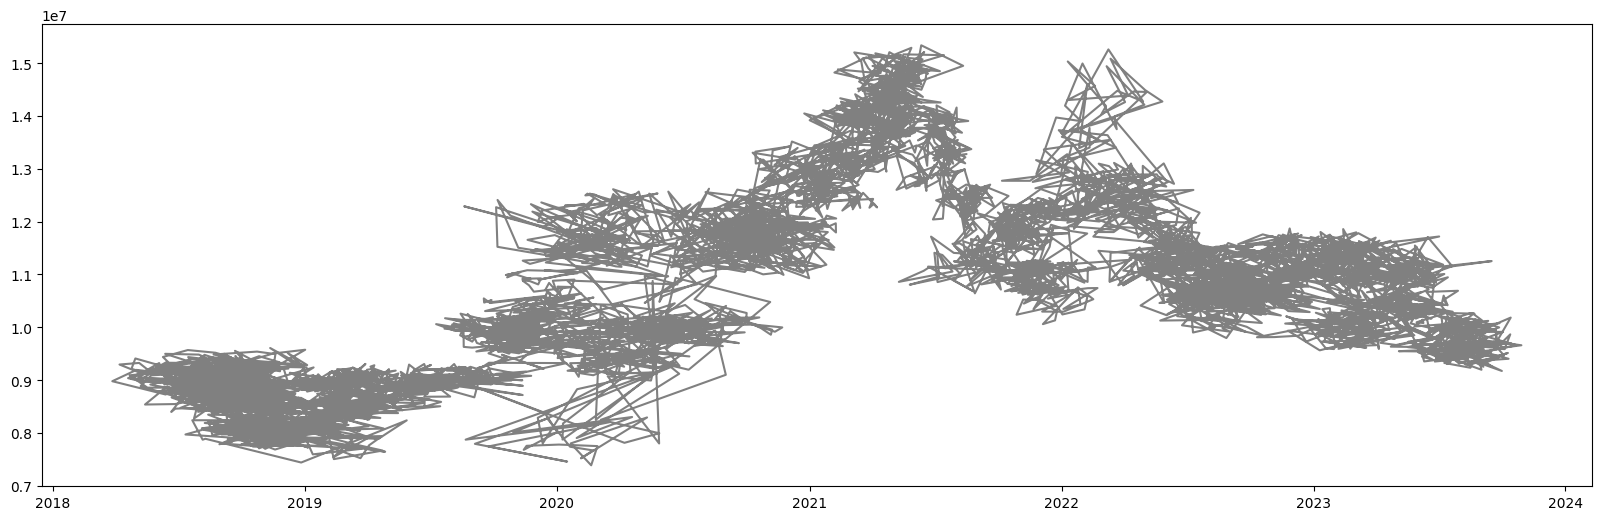

In [20]:
# Plot the data and change points
#plt.plot(df['Date'], df['Portfolio_Value'], label='Portfolio_Value', color="orange")
plt.plot(denormalized_predictions['Date'], denormalized_predictions['Portfolio_Value'], label='Portfolio_Value_Pred', color="gray")

In [25]:
# group change points
from sklearn.cluster import DBSCAN
# Reshape the data for DBSCAN (needed for sklearn)
X = all_regime_change_indices.reshape(-1, 1)

# DBSCAN parameters
epsilon = sequence_length * 2 # Maximum distance between points to be considered in the same neighborhood
min_samples = sequence_length  # Minimum number of samples in a neighborhood

In [26]:
# DBSCAN clustering
dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
dbscan.fit(X)

# Getting cluster labels and core sample indices
cluster_labels = dbscan.labels_
core_samples_mask = np.zeros_like(cluster_labels, dtype=bool)
core_samples_mask[dbscan.core_sample_indices_] = True

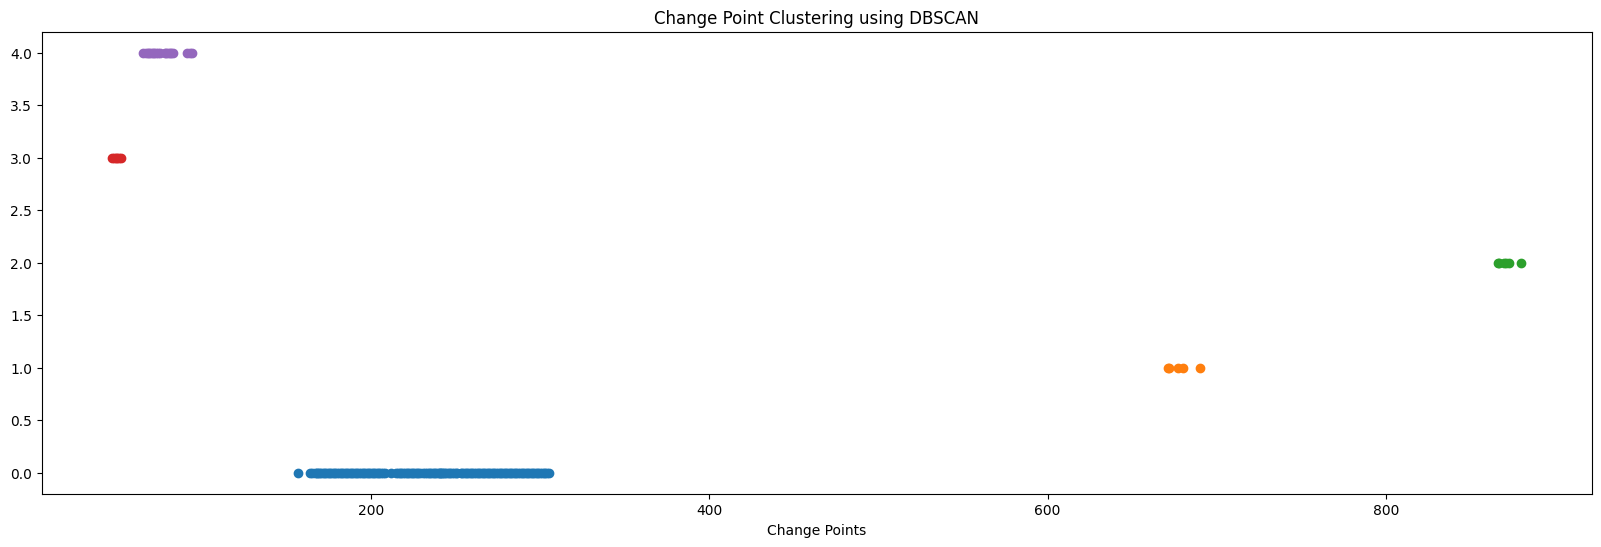

Cluster 0: Change Points - [array([157, 168, 241, 242, 164, 165, 167, 168, 169, 170, 171, 172, 173,
       174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186,
       187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199,
       200, 201, 202, 203, 204, 205, 206, 207, 208, 212, 215, 216, 217,
       218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 231,
       232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244,
       245, 246, 247, 248, 249, 250, 251, 253, 254, 255, 256, 257, 258,
       259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271,
       272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284,
       285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297,
       298, 299, 300, 301, 302, 303, 304, 305], dtype=int64)]
Cluster 1: Change Points - [array([671, 672, 677, 680, 690], dtype=int64)]
Cluster 2: Change Points - [array([866, 867, 870, 871, 873, 880], dtype=int64)]
Cluster 3: Change Points - [array([

In [27]:
from collections import defaultdict

# Extracting unique clusters and their indices
unique_labels = set(cluster_labels)
cluster_change_points = defaultdict(list)

if -1 in unique_labels:
    unique_labels.remove(-1)  # Remove noise label (-1)


for label in unique_labels:
    cluster_indices = np.where(cluster_labels == label)[0]
    cluster_points = all_regime_change_indices[cluster_indices]
    cluster_change_points[label].append(cluster_points)
    plt.plot(cluster_points, np.ones_like(cluster_points) * label, 'o', label=f'Cluster {label}')

plt.xlabel('Change Points')
plt.title('Change Point Clustering using DBSCAN')
# plt.legend()
plt.show()

# Print or process cluster-wise change points
for cluster, points in cluster_change_points.items():
    print(f"Cluster {cluster}: Change Points - {points}")

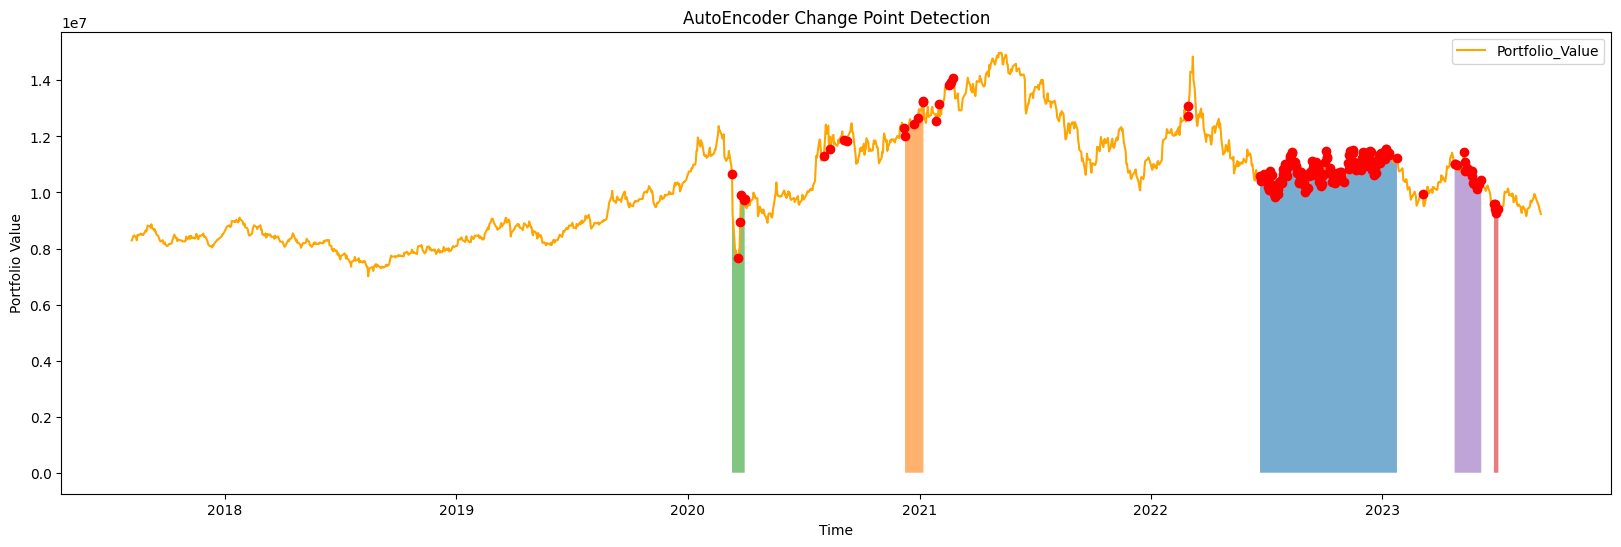

Change points detected at indices: [157 168 241 242 383 384 641 642 643 644 655 658 671 672 677 680 690 691
 755 756 773 780 866 867 870 871 873 880  47  48  49  50  51  52  65  67
  68  69  70  71  72  73  74  75  78  79  80  81  82  83  91  93  94 129
 164 165 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182
 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200
 201 202 203 204 205 206 207 208 212 215 216 217 218 219 220 221 222 223
 224 225 226 227 228 229 231 232 233 234 235 236 237 238 239 240 241 242
 243 244 245 246 247 248 249 250 251 253 254 255 256 257 258 259 260 261
 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279
 280 281 282 283 284 285 286 287 288 289 290 291 292 293 294 295 296 297
 298 299 300 301 302 303 304 305]


In [28]:
# Plot the data and change points
plt.plot(df['Date'], df['Portfolio_Value'], label='Portfolio_Value', color="orange")
#plt.scatter(df['Date'], [df['Volatility'][i] for i in change_points], color='red', marker='o', label='Change Points')
#plt.plot(denormalized_predictions['Date'], denormalized_predictions['Portfolio_Value'], label='Portfolio_Value_Pred', color="gray")


# Mark the change points on the chart
for change_point in all_regime_change_indices:
    plt.scatter(df['Date'][change_point], df['Portfolio_Value'][change_point], marker='o', color='red', zorder=3)

for cluster, points in cluster_change_points.items():
    # cluster_label = f"Cluster {cluster}"
    index_range = points[0]

    start_index = index_rall_regime_change_indicesange[0]
    end_index = index_range[len(index_range) -1]

    plt.fill_between(df['Date'][start_index:end_index+1], df['Portfolio_Value'][start_index:end_index+1], alpha=0.6)

plt.xlabel("Time")
plt.ylabel("Portfolio Value")
plt.title('AutoEncoder Change Point Detection')
plt.legend()
plt.show()

print("Change points detected at indices:", all_regime_change_indices)

In [ ]:
# Overlaying clustered change points on the original chart
for label in unique_labels:
    cluster_indices = np.where(cluster_labels == label)[0]
    cluster_points = all_regime_change_indices[cluster_indices]
    plt.plot(cluster_points, np.sin(cluster_points), 'o', label=f'Cluster {label}')


In [1]:
regimes = []

# Assuming 'data' is your DataFrame and 'all_regime_change_indices' contains change points
for i in range(len(all_regime_change_indices)):
    start_index = all_regime_change_indices[i]
    if i == len(all_regime_change_indices) - 1:
        end_index = len(df) - 1  # Use the last index of the data as the end index for the last regime
    else:
        end_index = all_regime_change_indices[i + 1]

    regime_window = df.iloc[start_index:end_index]
    regimes.append({
        'Regime': f'Regime_{i + 1}',
        'Start_Index': start_index,
        'End_Index': end_index,
        'Data': regime_window
    })

#regimes

NameError: name 'all_regime_change_indices' is not defined